In [27]:
from map_util import *

/home/ps2958/pps-election/maps/g5/coastal3.map


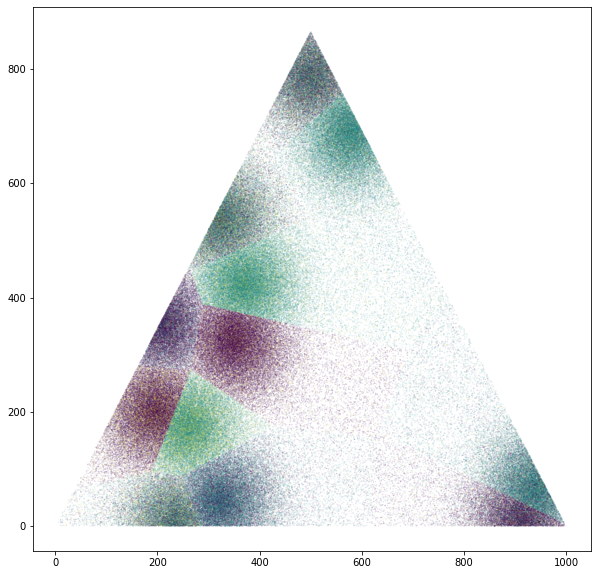

In [15]:
map_list = list_maps()
map_file = map_list[15]
print(map_file)

mmap = load_map(map_file)
visualize_map(mmap)

# Naive Gerrymandering

In [16]:
num_voters, num_parties = mmap.shape[0], mmap.shape[1]-2
num_districts, num_seats = 81, 243
print(num_voters, num_parties)

333333 3


In [17]:
# Enumerate the number of national victories on a completely even election
even_wins = np.bincount(np.argmax(mmap[:,2:], 1)) / num_voters * num_seats
even_count = np.rint(even_wins).astype(int)

In [18]:
def three_vote(vote_counts, return_summary=True):
    """
    Given an array of shape (num_districts, num_parties) with 
    arr[i][j] representing the number of votes the jth party
    received in district i, returns the number of electors each
    party gets in every district (or a summary of the total results)
    """
    # Calculate number of parties
    num_parties = vote_counts.shape[1]
    
    # Calculate vote percentage for each district
    vote_percentage = vote_counts / vote_counts.sum(1)[:,None]
    
    # Enumerate votes for each district
    elected_count = np.zeros_like(vote_counts)
    for i in range(3):
        electors = np.argmax(vote_percentage, 1)
        
        for p in range(num_parties):
            vote_percentage[electors==p, p] -= 0.25
            elected_count[electors==p, p] += 1
    
    return elected_count.sum(0) if return_summary else elected_count

In [19]:
THRESHOLDS = np.array([0, 0.25, 0.50, 0.75])[::-1]
def count_wasted_votes_2(party_votes, total_votes):
    for threshold in np.ceil(total_votes * THRESHOLDS):
        if party_votes >= threshold: break
    
    return party_votes - threshold

In [20]:
# Naive sorting then selecting
voter_list = mmap[mmap[:,1].argsort()]
current_winner = np.argmax(voter_list[:, 2:], 1)

In [21]:
# Uniform district election
uniform_split = np.array_split(current_winner, 81)
uniform_votes = np.array([np.bincount(split, minlength=num_parties) for split in uniform_split])

uniform_wins_1 = 3 * np.bincount(np.argmax(uniform_votes, 1), minlength=num_parties)
uniform_wins_2 = three_vote(uniform_votes)

print("Normal : ", uniform_wins_1)
print("Threes : ", uniform_wins_2)

Normal :  [ 84 159   0]
Threes :  [104 135   4]


In [22]:
d_left = 81
v_left = len(voter_list)

cur_idx = 0
MYPARTY = 0
g_min, g_max = np.ceil(0.91 * v_left/d_left).astype(int), np.floor(1.09 * v_left/d_left).astype(int)
print(f"Allowed range : [{g_min}, {g_max}]")

vote_counts = np.zeros((81, num_parties))
best_y_borders = np.zeros((81,))

total_wasted_votes = 0

for i in range(81):
#     print("Iteration ", i, " voters/districts left = ", v_left, d_left)
    d_left = d_left - 1

    min_voters = max(v_left - (g_max - 1) * d_left, g_min)
    max_voters = min(v_left - (g_min + 1) * d_left, g_max)
    
    # Create cumulative array for party votes and total votes
    party_votes = sum(current_winner[cur_idx:cur_idx+min_voters] == MYPARTY)
    
    party_cumsum = party_votes + np.cumsum(current_winner[cur_idx+min_voters: cur_idx+max_voters] == MYPARTY)
    total_cumsum = min_voters  + np.arange(party_cumsum.shape[0])
    
    # Calculate the closest threshold the party can get
    party_thresholds = np.ceil(total_cumsum[:, None] * THRESHOLDS)

    best_threshold_idx = (party_cumsum[:, None] >= party_thresholds).argmax(1)
    best_threshold = np.choose(best_threshold_idx, party_thresholds.T)

    # Calculate the number of wasted votes for each new voter
    wasted_votes = party_cumsum - best_threshold
    
#     print("Min party vote : ", party_votes)
#     print("Selection range : ", min_voters, max_voters)
#     print("Party cum sum  : ", party_cumsum)
#     print("Best Threshold : ", best_threshold)
#     print("Wasted votes   : ", wasted_votes)

    if i < 80:
        # Best wasted vote index
        best_idx = np.argmin(wasted_votes)

        best_num_voters   = total_cumsum[best_idx]
        best_wasted_votes = wasted_votes[best_idx]
        
        total_wasted_votes += best_wasted_votes
#         print("Best selection : ", best_num_voters, best_wasted_votes)
    else:
        best_num_voters = v_left

    # Accumulate votes
    for p in range(num_parties):
        vote_counts[i, p] = np.sum(current_winner[cur_idx: cur_idx+best_num_voters] == p)
    best_y_borders[i] = voter_list[cur_idx+best_num_voters][1] if i<80 else 500*np.sqrt(3)
    
    cur_idx += best_num_voters
    v_left  -= best_num_voters
    # print()

print(map_file)
print("Greedy : ", three_vote(vote_counts), total_wasted_votes)
print("Even   : ", even_count)
print("Normal : ", uniform_wins_1)
print("Threes : ", uniform_wins_2)

# print(vote_counts[:30])

Allowed range : [3745, 4485]
/home/ps2958/pps-election/maps/g5/coastal3.map
Greedy :  [106. 133.   4.] 33709.0
Even   :  [ 97 117  29]
Normal :  [ 84 159   0]
Threes :  [104 135   4]


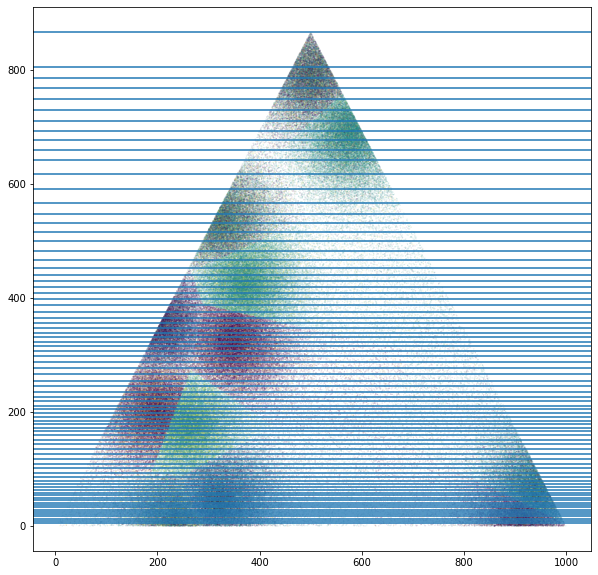

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
colors = np.argmax(mmap[:, 2:], 1)

for y_border in best_y_borders:
    ax.axhline(y_border)
    
plot = ax.scatter(mmap[:,0], mmap[:,1], s=0.01, c=colors, alpha=0.5)

In [25]:
prevy = 0
vertices = []
d_rt3 = 1/np.sqrt(3)

for newy in best_y_borders:
    vertices.append([
        prevy*d_rt3, prevy, 1000-prevy*d_rt3, prevy,
        1000-newy*d_rt3, newy,  newy*d_rt3, newy
    ])
    prevy = newy

In [26]:
with open("naive.dat", "w") as handle:
    np.savetxt(handle, mmap, fmt="%f", delimiter=' ', header=f"{num_voters} {num_parties}", comments='')
    np.savetxt(handle, vertices, fmt="4 "+"%f "*8, delimiter=' ', header="81", comments='')